# Moist GCM with a convective parameterisation
-------

Here, CliMT is configured as a simple moist GCM with a grey radiation scheme and
the simple physics package (Reed and Jablonowski (2012)) to provide surface fluxes, a
boundary layer, and the Emanuel convection scheme.

The GCM generates a weak circulation, but the vertical profiles of moisture and temperature
adjust quickly due to the presence of convection. The weak circulation is a consequence
of no water vapour sensitivity in the radiation scheme.

In [1]:
%matplotlib notebook

from climt.dynamics import dynamics
from climt.simple_physics_custom import simple_physics_custom
from climt.federation import federation
import climt

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid',rc={'grid.linestyle':'dotted', 'grid.color':'0.0'})
import xarray

# Initial conditions

data = xarray.open_dataset('init.nc')

U = data.U.values.astype('double')
V = data.V.values.astype('double')
T = data['T'].values.astype('double')
ps = data.ps.values.astype('double')
q = data.q.values.astype('double')

theta = T*(1 + 0.608*q)

# Dynamical core parameters

global_time_step = 1200.
rad_time_step = global_time_step*20

kwargs = {}
kwargs['dt'] = global_time_step
kwargs['nlon'] = 128
kwargs['nlat'] = 62

#Init the dynamics Component
dycore = dynamics(scheme='gfs', **kwargs)
dycore.Extension.initial_conditions(U,V,theta,ps,q)

#Get the pressure and lat/lon values
pressure = dycore['p']
ps = dycore['ps']

full_latitudes = dycore.Extension.latitudes
full_longitudes = dycore.Extension.longitudes

dycore_grid = dycore.Grid

Using netCDF4 interface for IO
Lats, lons, levs, trunc, dims, tracers 62 128 28 40 861 1


In [2]:
#Setup simple physics

kwargs['grid'] = dycore_grid
kwargs['dt'] = global_time_step
kwargs['p'] = pressure
kwargs['pint'] = dycore['pint']
kwargs['use_ext_ts'] = True
kwargs['lsc'] = False
#set surface temperatures
eq_pole_rad_gradient = 200.
max_rad = 400.

delta = eq_pole_rad_gradient/max_rad

solar_in = max_rad*(1 - delta*np.sin(full_latitudes)**2)

Ts = (solar_in/5.67e-8)**0.25

kwargs['Ts'] = Ts

phys = simple_physics_custom(**kwargs)

#Initialise radiation
kwargs = {}
kwargs['UpdateFreq'] = rad_time_step
kwargs['grid'] = dycore_grid
kwargs['solin'] = solar_in
kwargs['p'] = pressure
kwargs['zen'] = 90 - (np.degrees(abs(full_latitudes)))

rad = climt.radiation(scheme='ccm3', **kwargs)

#Initialise convection
kwargs = {}
kwargs['grid'] = dycore_grid
kwargs['dt'] = global_time_step

conv = climt.convection(scheme='emanuelnew', **kwargs)

Finished initialising emanuel convection scheme


gfs_dynamics  can integrate  ['U', 'V', 'T', 'q', 'ps']
All fields integrated by federation members:  ['U', 'V', 'T', 'q', 'ps']
All fields returned by federation members:  ['U', 'V', 'T', 'q', 'ps', 'p', 'pint']
 Wrote to file moistGcm_ccm32.nc, time=   0.00000 days


<IPython.core.display.Javascript object>


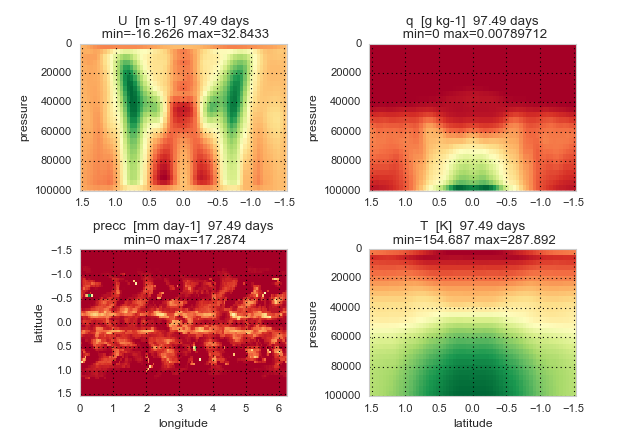

 Wrote to file moistGcm_ccm32.nc, time=   1.00000 days
 Wrote to file moistGcm_ccm32.nc, time=   2.00000 days
 Wrote to file moistGcm_ccm32.nc, time=   3.00000 days
 Wrote to file moistGcm_ccm32.nc, time=   4.00000 days
 Wrote to file moistGcm_ccm32.nc, time=   5.00000 days
 Wrote to file moistGcm_ccm32.nc, time=   6.00000 days
 Wrote to file moistGcm_ccm32.nc, time=   7.00000 days
 Wrote to file moistGcm_ccm32.nc, time=   8.00000 days
 Wrote to file moistGcm_ccm32.nc, time=   9.00000 days
 Wrote to file moistGcm_ccm32.nc, time=  10.00000 days
 Wrote to file moistGcm_ccm32.nc, time=  11.00000 days
 Wrote to file moistGcm_ccm32.nc, time=  12.00000 days
 Wrote to file moistGcm_ccm32.nc, time=  13.00000 days
 Wrote to file moistGcm_ccm32.nc, time=  14.00000 days
 Wrote to file moistGcm_ccm32.nc, time=  15.00000 days
 Wrote to file moistGcm_ccm32.nc, time=  16.00000 days
 Wrote to file moistGcm_ccm32.nc, time=  17.00000 days
 Wrote to file moistGcm_ccm32.nc, time=  18.00000 days
 Wrote to 

In [ ]:
#Setup federation
kwargs = {}
kwargs['Ts'] = Ts
kwargs['MonitorFields'] = ['U','q','precc','T'] # Display zonal velocity during simulation
kwargs['MonitorFreq'] = 1200. #hourly update
kwargs['OutputFile'] = 'moistGcm_ccm32.nc'
kwargs['OutputFreq'] = 86400.
kwargs['grid'] = dycore_grid
kwargs['dt'] = global_time_step
kwargs['OutputFields'] = ['U','V','q','T','ps','precc']
kwargs['solin'] = solar_in
kwargs['p'] = pressure
kwargs['zen'] = 90 - (np.degrees(abs(full_latitudes)))

fed = federation(dycore, rad, phys,conv, **kwargs)
#Run the code for 10 days. each time step is 1200 seconds = 1/3 hour
num_steps = 1000*24*3
for i in range(num_steps):
    #Integrate one time step
    fed.step()